In [1]:
import os 
import asyncio
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
import smtplib


load_dotenv()
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GOOGLE_API_KEY"]=os.getenv("GOOGLE_API_KEY")

llm = ChatGroq(model="deepseek-r1-distill-llama-70b", max_tokens=2000, temperature=0)
llm2 = ChatOpenAI(model="gpt-4o", temperature=0,max_tokens=2000)

In [2]:
from typing import Optional, TypedDict, List
from pydantic import BaseModel, Field
from langchain_google_genai import GoogleGenerativeAIEmbeddings


embedding_model=GoogleGenerativeAIEmbeddings(model="models/embedding-001")

from langchain.schema import Document
from langchain.vectorstores import Chroma

In [3]:

vectorstore = Chroma(
    collection_name="resume_collection",
    embedding_function=embedding_model,
    persist_directory="./chromaDB"
    )


/var/folders/d_/rqsk7t093dlg0nzx8rc5n4fh0000gn/T/ipykernel_79460/2185028648.py:1: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


In [4]:
class email(BaseModel):
    ar_requestor: str
    recruiter : str

In [5]:
class State(TypedDict):
    resumes_dir_path: str
    jd: str
    text_resumes: List[str]  # List of text representations of resumes
    matched_resumes: List  # List of Document objects from vector store
    ranked_resumes: List  # List of Document objects ranked by relevance
    no_match: bool
    emails: Optional[email]  # Made optional and fixed typo
    resume_file_path_mapping: dict  # New field to store name -> pdf_path mapping

In [6]:
from langchain_core.messages import HumanMessage, SystemMessage


In [7]:
os.environ["LLAMA_CLOUD_API_KEY"] = os.getenv("LLAMA_CLOUD_API_KEY")

In [8]:
from llama_cloud_services import LlamaExtract
from llama_cloud_services.extract import SourceText



extractor = LlamaExtract()

class Resume(BaseModel):
    name: str = Field(description="Full name of candidate")
    email: str = Field(description="Email address")
    skills: list[str] = Field(description="Technical skills and technologies")
    work_experience: list[str] = Field(description="Work experience details")
    education: str = Field(description="Educational background")
    projects: list[str] = Field(description="Projects worked on")


class RankedResumes(BaseModel):
    ranked_resumes: List[Resume] = Field(description="List of resumes ranked by relevance to the job description")


In [9]:
class RankedResumes(BaseModel):
    ranked_resumes: List[Resume] = Field(description="List of resumes ranked by relevance to the job description")


str_llm = llm.with_structured_output(RankedResumes)
str_llm2 = llm2.with_structured_output(RankedResumes)

In [10]:


agent = extractor.create_agent(name="resume-parser546", data_schema=Resume)
agent2 = extractor.create_agent(name="ranked_resumes1400", data_schema=RankedResumes)


In [11]:
def resume_to_text(resume):
    text = f"{resume['name']} is a skilled professional.\n"
    text += f"Email: {resume['email']}\n"
    text += f"Skills: {', '.join(resume['skills'])}\n"
    
    text += "\nWork Experience:\n"
    for exp in resume['work_experience']:
        text += f"- {exp}\n"

    text += f"\nEducation: {resume['education']}\n"

    text += "\nProjects:\n"
    for proj in resume['projects']:
        text += f"- {proj}\n"

    return text.strip()

## Extracting And Storing Resumes in VectorStore

In [12]:
async def extract_and_store_resumes(state: State):
    "Extract the text from resumes and store them in vectorstore"
    resumes_dir_path = state["resumes_dir_path"]
    pdf_files = []
    job_to_file_mapping = {}
    for file in os.listdir(resumes_dir_path):
        if file.endswith(".pdf"):
            pdf_files.append(os.path.join(resumes_dir_path, file))

    jobs = await agent.queue_extraction(pdf_files)
    print(f"Queued {len(jobs)} extraction jobs")

    for i, job in enumerate(jobs):
        job_to_file_mapping[job.id] = pdf_files[i]

    
    # Wait for all jobs to complete
    results = []
    for job in jobs:
        # Keep checking until the job is complete
        while True:
            result = agent.get_extraction_run_for_job(job.id)
            status = result.status.value
            
            if status in ['COMPLETED', 'SUCCESS']:  # Handle both possible success statuses
                results.append(result)
                print(f"Job {job.id} completed successfully")
                break
            elif status == 'FAILED':
                print(f"Job {job.id} failed: {result.error}")
                break
            else:
                print(f"Job {job.id} status: {status}, waiting...")
                await asyncio.sleep(2)  # Wait 2 seconds before checking again
    
    print(f"All jobs completed. Processing {len(results)} results.")
    resumes = []
    resume_file_mapping = {}

    for result in results:
        if result.data:  # Check if data exists
            file_path = job_to_file_mapping.get(result.job_id)
            resume_info = {
                'name': result.data["name"],
                'email': result.data["email"],
                'skills': result.data["skills"],
                'work_experience': result.data["work_experience"],
                'education': result.data["education"],
                'projects': result.data["projects"]
            }
            resumes.append(resume_info)

            resume_file_mapping[resume_info["name"]] = file_path
        else:
            print(f"Warning: No data found for job {result.job_id}")
    
    text_resumes = [resume_to_text(resume) for resume in resumes]



    docs = []

    for resume in resumes:
        text = resume_to_text(resume)
        doc = Document(
            page_content=text,
            metadata={
                "name": resume["name"],
                "email": resume["email"],
                "skills": ', '.join([s.lower().strip() for s in resume["skills"]])
            }
        )
        docs.append(doc)
    vectorstore.add_documents(docs)
    vectorstore.persist()
    
    return {"text_resumes": text_resumes, "resume_file_path_mapping": resume_file_mapping}

## Comparison Agent

In [13]:
async def comparison_agent(state: State):
    '''This node will compare the JD with resume and give the matching resumes'''

    jd_text = state["jd"]


    matched_resumes = vectorstore.similarity_search(jd_text, k=3)

    return {"matched_resumes": matched_resumes}





## Ranking Agent 

In [14]:
async def ranking_agent(state: State):
    '''This node will rank the matched resumes based on their relevance to the JD'''

    matched_resumes = state["matched_resumes"]
    
    if not matched_resumes:
        return {"ranked_resumes": [], "no_match": True}
    
    # Convert Document objects to a simpler format for ranking
    resume_texts = []
    for doc in matched_resumes:
        resume_info = {
            "name": doc.metadata.get("name", "Unknown"),
            "email": doc.metadata.get("email", "Unknown"),
            "content": doc.page_content,
            "skills": doc.metadata.get("skills", "")
        }
        resume_texts.append(resume_info)
    
    # Create a simpler prompt for ranking without structured output
    ranking_prompt = f"""
    Job Description: {state['jd']}
    
    Please rank the following resumes from most relevant (1) to least relevant based on the job description.
    Return only the ranking as a numbered list with name and email.
    Return all the resumes in the order of their relevance to the job description.
    You must provide me the name, email, skills and work experience of each resume in the ranking list
    
    Resumes to rank:
    """
    
    for i, resume in enumerate(resume_texts, 1):
        ranking_prompt += f"\n{i}. Name: {resume['name']}\n   Email: {resume['email']}\n   Skills: {resume['skills']}\n   Content: {resume['content'][:500]}...\n"
    
    print("calling LLM")
    # Use regular LLM invoke instead of structured output
    ranking_response = llm.invoke([
        SystemMessage(content="You are a recruitment expert. Rank the resumes based on their relevance to the job description."),
        HumanMessage(content=ranking_prompt)
    ])

    print(f"Ranking response: {ranking_response.content}")
    
    # For now, return the original matched resumes in order (since vector store already does similarity matching)
    # The LLM response can be used for additional insights
    ranked_resumes = agent2.extract(SourceText(text_content=ranking_response.content))
    
    return {"ranked_resumes": ranked_resumes.data["ranked_resumes"], "no_match": False}

## Communicator Agent

In [15]:
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.application import MIMEApplication


async def communicator_agent(state: State):
    "This agent is responsible for sending emails to the recruiter and the applicant"

    no_match = state["no_match"]
    emails = state["emails"]

    ranked_resumes = state["ranked_resumes"]
    resume_file_path_mapping = state["resume_file_path_mapping"]


    if not emails:
        print("No email configuration provided, skipping email sending.")
        return
    smtp_server = os.getenv("SMTP_SERVER", "smtp.gmail.com")
    smtp_port = int(os.getenv("SMTP_PORT", "587"))
    sender_email = os.getenv("SENDER_EMAIL")
    sender_password = os.getenv("SENDER_PASSWORD")

    if not sender_email or not sender_password:
        print("Email credentials not configured")
        return

    try:
        server = smtplib.SMTP(smtp_server, smtp_port)
        server.starttls()
        server.login(sender_email, sender_password)

        if no_match:

            msg = MIMEMultipart()
            msg['From'] = sender_email
            msg['To'] = emails.recruiter
            msg['Subject'] = "No Matching Resumes Found"

            body = f"Dear Recruiter,\n\nWe could not find any resumes matching the job description.\n\nBest regards,\nRecruitment Team"
            msg.attach(MIMEText(body, 'plain'))

        else:
            msg = MIMEMultipart()
            msg['From'] = sender_email
            msg["To"] = emails.ar_requestor
            msg['Subject'] = "Ranked Resumes for Job Description"

            top_resumes = ranked_resumes[:3]  # Get top 3 resumes

            candidates_info = ""
            for i, candidate in enumerate(top_resumes, 1):
                candidates_info += f"""
                {i}. Name: {candidate["name"]}
                   Email: {candidate["email"]}
                   Skills: {', '.join(candidate["skills"])}
                   
                   Work Experience:
                   {chr(10).join(f'   - {exp}' for exp in candidate["work_experience"])}
                   
                   Education: {candidate["education"]}
                   
                   Projects:
                   {chr(10).join(f'   - {proj}' for proj in candidate["projects"])}
                   
                   {'='*50}
                """
            
            body = f"""
            Dear AR Requestor,
            
            We have found matching candidates for your job description. Here are the top 3 candidates:
            
            {candidates_info}
            
            Please review these candidates and let us know if you need any additional information.
            
            Best regards,
            Resume Matching System
            """

            msg.attach(MIMEText(body, 'plain'))

            for candidate in top_resumes:
                candidate_name = candidate["name"]
                resume_file_path = resume_file_path_mapping.get(candidate_name)

                if resume_file_path and os.path.exists(resume_file_path):
                    try:
                        with open(resume_file_path, 'rb') as file:
                            attachment = MIMEApplication(file.read(), _subtype='pdf')
                            attachment.add_header('Content-Disposition', 'attachment', filename=f"{candidate_name}_resume.pdf")
                            msg.attach(attachment)
                    except Exception as e:
                        print(f"Failed to attach resume for {candidate_name}: {e}")

        text = msg.as_string()
        server.sendmail(sender_email, msg['To'], text)
        server.quit()
        print(f"Email sent successfully to {msg['To']}")
    except Exception as e:
        print(f"Failed to send email: {e}")
    
    return None



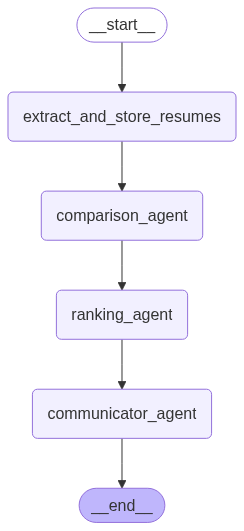

In [16]:
from langgraph.graph import StateGraph, END, START
from IPython.display import Image, display

flow = StateGraph(State)

flow.add_node("extract_and_store_resumes", extract_and_store_resumes)
flow.add_node("comparison_agent", comparison_agent)
flow.add_node("ranking_agent", ranking_agent)
flow.add_node("communicator_agent", communicator_agent)

flow.add_edge(START, "extract_and_store_resumes")
flow.add_edge("extract_and_store_resumes", "comparison_agent")
flow.add_edge("comparison_agent", "ranking_agent")
flow.add_edge("ranking_agent", "communicator_agent") 
flow.add_edge("communicator_agent", END)

chain = flow.compile()
display(Image(chain.get_graph().draw_mermaid_png()))


In [17]:
email_config = email(
    ar_requestor="yashstudy02@gmail.com",
    recruiter="techwariumdev@gmail.com"
)


In [18]:
res = await chain.ainvoke({"resumes_dir_path": "/Users/yashpatil/Developer/AI/ResumeJDMatcher/data", "jd": """Seeking a proficient React Developer to design, build, and maintain high-performance and scalable user interfaces for our modern web applications.
""", 
"emails": email_config
})

I0000 00:00:1753642634.329947 3611884 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
Creating extraction jobs: 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]


Queued 7 extraction jobs
Job 04c93905-a023-44c2-b642-18eaf1d74cca status: PENDING, waiting...
Job 04c93905-a023-44c2-b642-18eaf1d74cca status: PENDING, waiting...
Job 04c93905-a023-44c2-b642-18eaf1d74cca completed successfully
Job 0a65c8af-761e-4a5e-b387-3a7ec9f286aa completed successfully
Job 850f7260-eb5d-40c9-9470-23a6eabd221c completed successfully
Job 6bd02fe8-2b79-4c38-a9be-c9cb9c0924e9 completed successfully
Job 83aeb750-2d7e-4170-8df7-d13dbf713958 completed successfully
Job e98bbcf1-29e6-4f3d-97a4-9ddbc3deab5d completed successfully
Job f6a76519-5192-428f-a79b-f14bdb79e55b completed successfully
All jobs completed. Processing 7 results.


/var/folders/d_/rqsk7t093dlg0nzx8rc5n4fh0000gn/T/ipykernel_79460/286119201.py:75: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectorstore.persist()


calling LLM
Ranking response: <think>
Okay, so I need to rank these three resumes based on how well they fit the job description for a React Developer position. The job is looking for someone who can design, build, and maintain high-performance and scalable user interfaces using React. 

First, I'll look at each resume one by one and compare their skills and work experience to the job requirements.

Starting with Giulia Rossi. Her skills include HTML, CSS, JavaScript, React, and Responsive Design. She's a Junior Front End Developer and has experience collaborating on a responsive e-commerce site using React. She improved user engagement by 30% and did cross-browser testing. That's good, but she's a junior, so maybe less experience than others.

Next, Aditi Sharma. Her skills are HTML, CSS, JavaScript, React.js, Responsive Design, UX/UI Design, and Git. She's a Front End Developer with more experience, having designed interfaces for 10+ web apps. She worked with UX/UI designers and used

Extracting files: 100%|██████████| 1/1 [00:03<00:00,  3.27s/it]


Email sent successfully to yashstudy02@gmail.com


In [19]:
res

{'resumes_dir_path': '/Users/yashpatil/Developer/AI/ResumeJDMatcher/data',
 'jd': 'Seeking a proficient React Developer to design, build, and maintain high-performance and scalable user interfaces for our modern web applications.\n',
 'text_resumes': ['Yash Patil is a skilled professional.\nEmail: Yashstudy02@gmail.com\nSkills: JavaScript (ES6+), Node.js, Python, TypeScript, React, Express, MongoDB, Next.js, streamlit, Figma, Canva, Premier Pro, AWS, Netlify, Vercel, RESTful API, Git, Postman, Npm, Stripe, Firebase, Axios, React Router, Agile Experience, Responsive & Mobile-First Design, CI/CD Pipeline using Github\n\nWork Experience:\n- UX Designer and Web Developer Intern at Techwarium from Aug 2024 to Oct 2024.\n- UX Designer and Web Developer Intern at Techwarium from Dec 2024 to Feb 2024.\n\nEducation: B.E. (CSE), AITR, RGPV Bhopal, 2025, 7.1 CGPA; 12th, Shree Vaishnav Academy, CBSE, 2020, 82%; 10th, Shree Vaishnav Academy, CBSE, 2018, 82%\n\nProjects:\n- SpaceWeather: Developed a

In [20]:
res["ranked_resumes"][0]["name"]

'Emma Dupont'

In [21]:
res["matched_resumes"]

[Document(metadata={'skills': 'html, css, javascript, react, responsive design', 'name': 'Giulia Rossi', 'email': 'giulia.rossi@example.com'}, page_content='Giulia Rossi is a skilled professional.\nEmail: giulia.rossi@example.com\nSkills: HTML, CSS, JavaScript, React, Responsive Design\n\nWork Experience:\n- Junior Front End Developer at WEBINNOVATE, Milan, Italy (Jun 2022 - Present): Collaborated in a team to develop a responsive e-commerce website, improving user engagement by 30%. Implemented user interface designs using React, enhancing the overall user experience. Conducted cross-browser testing and debugging to ensure compatibility and performance.\n- Front End Intern at CREATIVE SOLUTIONS, Rome, Italy (Jan 2021 - May 2022): Assisted in developing web applications using HTML, CSS, and JavaScript, contributing to a 15% increase in website traffic. Worked closely with designers to translate visual concepts into functional web pages. Participated in code reviews and contributed to t